# Exames cardiotopagico
[Referencia]("https://blog.medicalway.com.br/cardiotocografia-entenda-a-importancia-para-a-saude-do-bebe/")

A cardiotocografia (CTG) é um exame que registra da atividade cardíaca do bebe, observa as contrações uterinas e os movimentos fetais.  
  
A interpretação do exame é realizada por meio de uma análise do traçado resultante da atividade cardíaca fetal e de sua variabilidade — ou seja, espera-se que a frequência cardíaca fetal varie junto com movimentos e contrações uterinas. Os padrões esperados de variabilidade são bem documentados e, assim, detectam as alterações com mais facilidade.  

A CTG é um exame prático — pois não precisa da presença do operador ao lado da gestante —, relativamente barato e que traz resultados bastante confiáveis.  

O exame de CTG é comumente solicitado no final da gravidez, após 38 semanas em gestações que transcorrem normalmente, durante o trabalho de parto ou a qualquer momento (em gestações acima de 30 semanas), desde que haja necessidade de avaliar a vitalidade fetal.  

A cardiotocografia (CTG) é fundamental para garantir que a gestação transcorre bem nas últimas semanas. Isso porque o resultado do exame, quando mostra algum desvio, pode indicar insuficiência na oxigenação cerebral do bebê. Essa deficiência pode ser causada por vários fatores, como:

1. posição do feto;
2. problemas na placenta;
3. cordão umbilical enrolado no pescoço do bebê.

# Quais sinais indicam sofrimento fetal?
A cardiotocografia pode detectar sinais de sofrimento fetal. São eles:

1. FCF (Frequência Cardíaca Fetal) acima de 160 batimentos por minuto, que permanece assim, indica taquicardia fetal;
2. FCF abaixo de 110 batimentos por minuto indica bradicardia fetal;
3. o normal é que a FCF varie de acordo com os movimentos dos bebês ou quando ele escuta um barulho alto. Caso essa frequência permaneça constante ela indica sofrimento fetal;
4. quedas significativas na FCF demonstram desacelerações na frequência cardíaca do bebê;
5. desacelerações na FCF após as contrações podem indicar que o oxigênio do feto está diminuindo.


## Importando Bibliotecas e Datasets

In [100]:
#bibliotecas para plotagem de gráficos e tratamento de dados.
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#Normalização de dados.
from sklearn.preprocessing import StandardScaler
#Validação K fold
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score 

#Modelo KNN
from sklearn.neighbors import KNeighborsClassifier

#Tunagem  de hyper-paramentros
from sklearn.model_selection import GridSearchCV

#Modelo Arvore de decisão 
from sklearn.tree import DecisionTreeClassifier

#Desenho de gráfico
from sklearn.tree import export_graphviz
from six import StringIO
from IPython.display import Image  
import pydotplus

#Modelo SVM
from sklearn import svm

# metricas 
from sklearn import metrics

In [101]:
df = pd.read_excel('./CTG.xls',sheet_name='Raw Data',header=0).drop(index=[0,2127,2128,2129]).drop(labels=["FileName","SegFile","Date"],axis=1)

## Análise exploratória 

Primeira etapa é verificar o percentual de nulos existentes no Dataframe, visto que não podemos aplicar um algoritmo em dados nulos, temos que fazer essa limpeza, esse processo é conhecido como data cleaning.  
Se o percentual de nulos for muito alto devemos descartar a feature, porém caso seja baixo o percentual podemos apenas eliminar algumas linhas.

In [102]:
colunas= ['LB','AC','FM','UC','DL','DS','DP','ASTV','MSTV','ALTV','MLTV','Width','Min','Max','Nmax','Nzeros','Mode','Mean','Median','Variance','Tendency','NSP']
df = df[colunas]

#Para cada coluna em df calcule  o % de nulos.
[ (i, f"{(df[i]==np.nan).mean()*100}%") for i in df]

[('LB', '0.0%'),
 ('AC', '0.0%'),
 ('FM', '0.0%'),
 ('UC', '0.0%'),
 ('DL', '0.0%'),
 ('DS', '0.0%'),
 ('DP', '0.0%'),
 ('ASTV', '0.0%'),
 ('MSTV', '0.0%'),
 ('ALTV', '0.0%'),
 ('MLTV', '0.0%'),
 ('Width', '0.0%'),
 ('Min', '0.0%'),
 ('Max', '0.0%'),
 ('Nmax', '0.0%'),
 ('Nzeros', '0.0%'),
 ('Mode', '0.0%'),
 ('Mean', '0.0%'),
 ('Median', '0.0%'),
 ('Variance', '0.0%'),
 ('Tendency', '0.0%'),
 ('NSP', '0.0%')]

Como estamos com um dataframe já preparado não haverá necessidade de data cleaning.

A segunda etapa é um processo de feature engineer escolher as melhores features para criar o modelo de machine learning.  
  
Para isso vamos falar um pouco sobre correlação.  
A correlação é a medida de ligação entre duas característcas, exemplo 
```
Uma pizzaria faz 120 pizzas por hora com 3 fornos e 10 funcionários.
Se um forno quebra, há uma redução na produção de pizzas para 80 pizzas por hora.
Com os 3 fornos funcionando perfeitamente com apenas 5 funcionários a produção de pizzas reduz para 100 pizzas por hora.
Temos então um alta correlação entre pizzas por hora e quantidade de fornos, porém uma correlação mais baixa entre número de funcionários e pizzas por hora.
```

A correlação de spearman serve para dados que não estão dentro de uma distribuição de dados normal, por isso é melhor indicada se não sabe-se como os dados evoluem.

<AxesSubplot:>

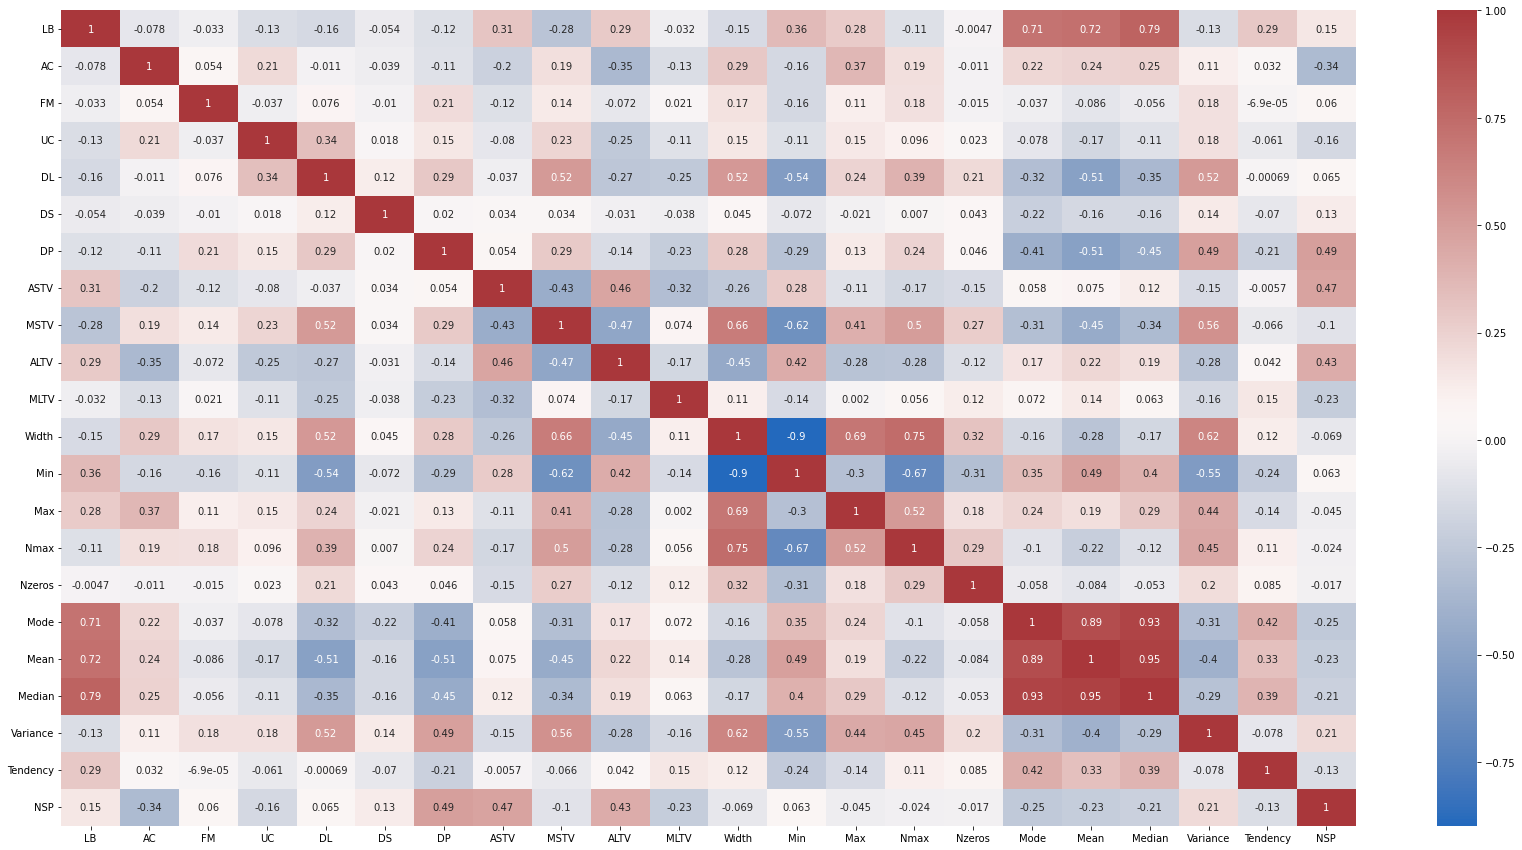

In [103]:
df_corr = df
fig, ax = plt.subplots(figsize=(29, 15))
sns.color_palette("vlag", as_cmap=True)
sns.heatmap(df_corr.corr(),annot=True,cmap='vlag')

Observando a linha do nosso target NSP na última linha do heatmap, as features LD, FS, SUSP e CLASS tem maior correalçao positiva.  
Enquanto A,B e AD maior correlação negativa, em outras palavras inversamente proporcional.  
``` A correlação de C e D impactam pouco no target poderiamos retirar-las.```

Agora vamos normalizar os dados, o modelo pode até ser feito sem essa etapa, porém essa etapa garante um melhor desempenho dos algoritimos a seguir como por exemplo: SVM, Decision Tree e KNN.  
Antes é preciso explicar a normalização de dados, imagine que esta constuindo um modelo para classificar uma doença ou não doença, tenha um campo em nanometros e outro em unidades.  
Um descrito como 10 elevado a -9 e outro 10 elevado a 0, nesse cenário o modelo teria dificuldades para fazer as contas necessárias.   
``` não confunda Normalização de dados com Forma Normal de banco de dados.```

<AxesSubplot:>

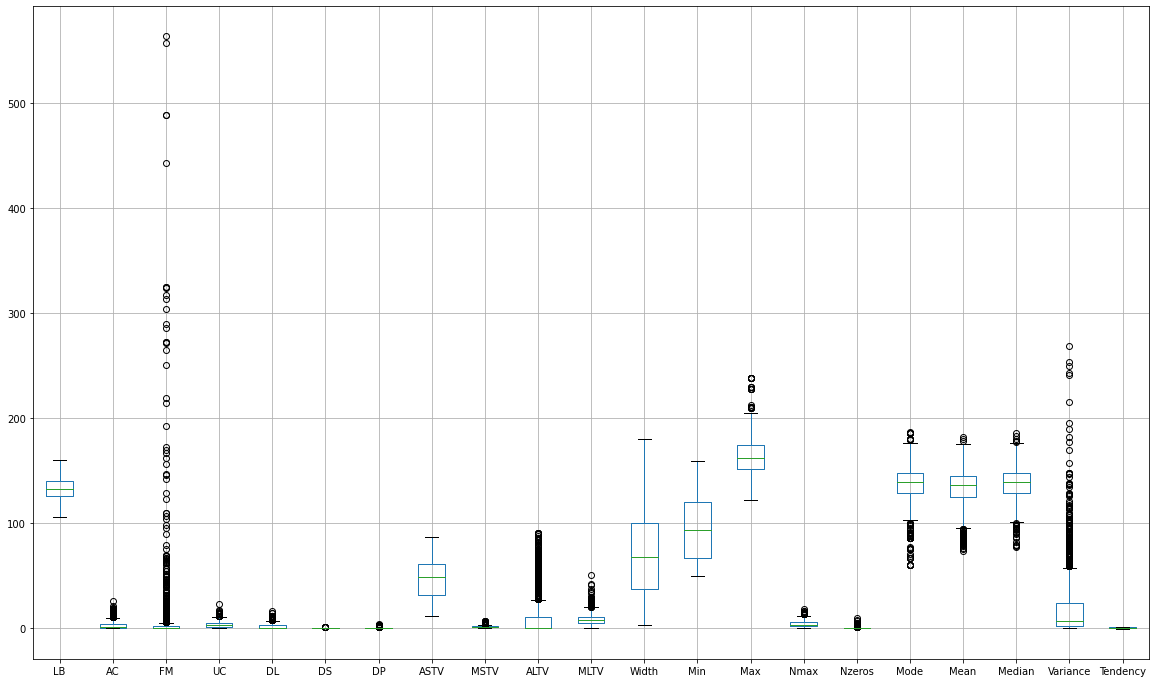

In [104]:
df.drop('NSP',axis=1).boxplot(figsize=(20,12))

Aqui vemos um grande número de outlines em FM, as medianas se variam bastante entre as features.

<AxesSubplot:>

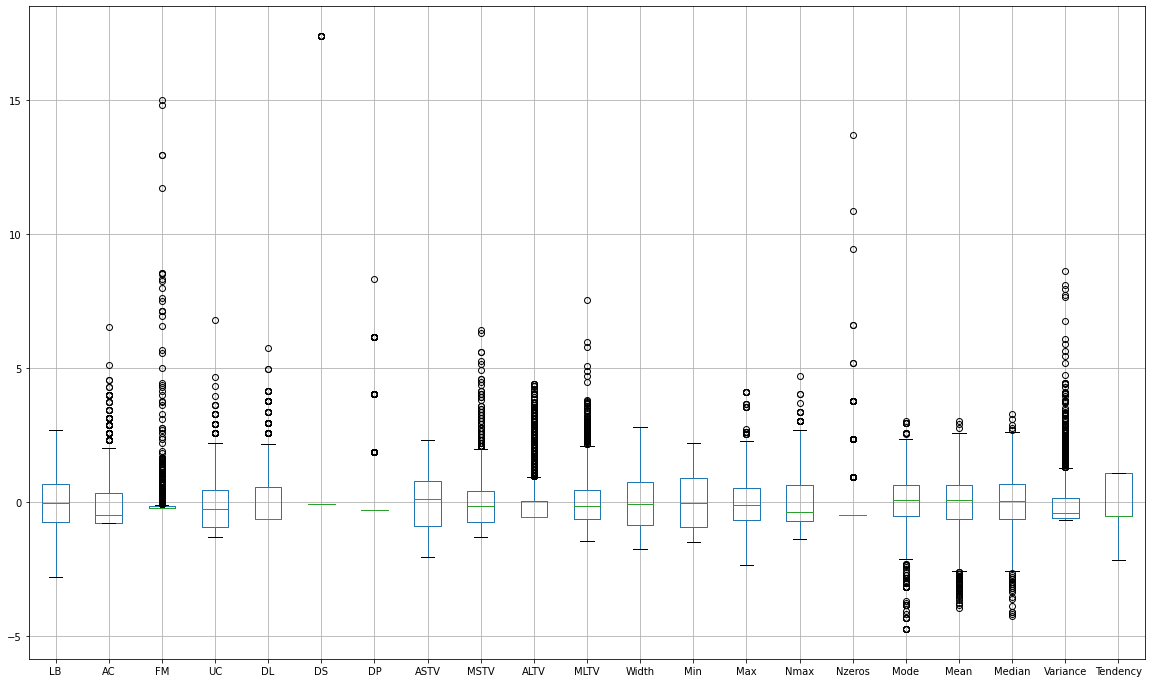

In [105]:
X = df.drop('NSP',axis=1)
y = df['NSP']

scaler = StandardScaler(copy=False)
scaler.fit(X)
scaler.transform(X)
X.boxplot(figsize=(20,12))

## KNN 
[Referencia kfold]("https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html?highlight=k%20fold#sklearn.model_selection.KFold.split")  
[Como usar o kfold]("https://drigols.medium.com/introdu%C3%A7%C3%A3o-a-valida%C3%A7%C3%A3o-cruzada-k-fold-2a6bced32a90")

In [106]:
knn = pd.DataFrame()
split = 10
X_train,X_test,y_train,y_test = train_test_split(X, y, train_size = 0.7, random_state = 42)

In [107]:
knn3 =  KNeighborsClassifier(n_neighbors=3)
knn3.fit(X_train,y_train)
kfold  = KFold(n_splits = split, shuffle=True,random_state=1)
knn[3] = cross_val_score(knn3, X, y, cv = kfold) 

In [108]:
knn5 =  KNeighborsClassifier(n_neighbors=5)
knn5.fit(X_train,y_train)
kfold  = KFold(n_splits=split, shuffle=True,random_state=1)
knn[5] = cross_val_score(knn5, X, y, cv = kfold) 

In [109]:
knn7 = KNeighborsClassifier(n_neighbors=7)
knn7.fit(X_train,y_train)
kfold  = KFold(n_splits=split, shuffle=True,random_state=1)
knn[7] = cross_val_score(knn7, X, y, cv = kfold) 

In [110]:
knn9 =  KNeighborsClassifier(n_neighbors=9)
knn9.fit(X_train,y_train)
kfold  = KFold(n_splits=split, shuffle=True,random_state=1)
knn[9] = cross_val_score(knn9, X, y, cv = kfold) 

<AxesSubplot:>

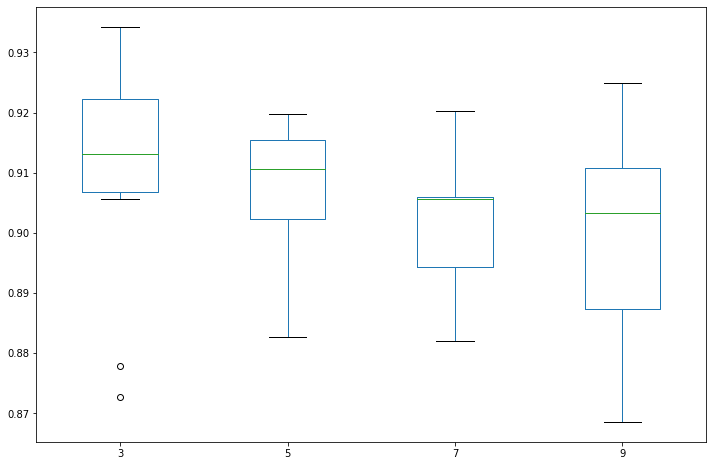

In [111]:
knn.boxplot(figsize=(12,8),grid=False)

In [112]:
knn.describe()

3          5          7          9
count  10.000000  10.000000  10.000000  10.000000
mean    0.910147   0.907808   0.901690   0.899344
std     0.020798   0.010893   0.011434   0.017732
min     0.872642   0.882629   0.882075   0.868545
25%     0.906840   0.902233   0.894366   0.887324
50%     0.913146   0.910588   0.905660   0.903302
75%     0.922269   0.915493   0.905993   0.910798
max     0.934272   0.919811   0.920188   0.924883

In [113]:
y_pred = knn5.predict(X_test)

### Métrica Acurácia

In [114]:
print('Accuracy       :', metrics.accuracy_score(y_test, y_pred))


Accuracy       : 0.9106583072100314


### Métrica Precisão 

In [115]:
print('Precision macro:', metrics.precision_score(y_test, y_pred,average='macro'))
print('Precision micro:', metrics.precision_score(y_test, y_pred,average='micro'))

Precision macro: 0.8442612703419808
Precision micro: 0.9106583072100314


### Métrica Revocação

In [116]:
print('Recall    macro:', metrics.recall_score(y_test, y_pred,average='macro'))
print('Recall    micro:', metrics.recall_score(y_test, y_pred,average='micro'))

Recall    macro: 0.8108928418412257
Recall    micro: 0.9106583072100314


## Árvore de decisão
[Decision tree](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html?highlight=decision%20tree#sklearn.tree.DecisionTreeClassifier)  
  
Por padrão a árvore de decisão é configurada para ter profundidade máxima, caso não especifique o ```max_depth```, isso é um problema.  
Ao entrar um dado completamente novo a árvore terá dificuldade em classificar, pois com uma profundidade muito grande o modelo tende ao overfit, ou seja decorar os dados.  
Em contrapartida ao overfit temos o underfit que é um modelo muito 'fraco' que não consegue 'acertar' muito bem o resultado.  
Sendo assim definimos um tamanho considerável e fazemos os testes, esse processo se chama tunagem de hiperparametros, a escolha de configuração que gera o melhor modelo.

### GridSearch
[GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)  
  
O GridSearch é um recurso do scikit learn para tunagem de hiper-parametros.  
Imagine o algoritmo árvore de decisão, testar varios valores de ```max_depth```.  
1. Criar um modelo para cada valor
2. Calcular os scores desejados 
3. Escolher a melhor valor do ```max_depth``` e usar esse modelo.  
  
Porém o algoritmo tem mais hiper-paramentros, como: critério, n° de folhas e outros mais.  
Seria necessário fazer uma combinação de todos esses hiper-parametros, aumentado a complexidade e difculdade de escolha.  
  
  
Para isso existe o GridSearchCV dado uma métrica, ou seja score, ele recebe um dicionario com hiper-parametros, um objeto algoritmo i.e. Decision Tree.  
Realiza todas possibilidades e realiza validação cruzada para escolha da melhor configuração.

In [117]:
import time

X_train,X_test,y_train,y_test=train_test_split(X,y,train_size=0.7)


start = time.time()

grid_gini = [
    {
        'criterion':['gini'],
        'max_depth':range(2,30)
    }]

grid_dt_gini = GridSearchCV(
    DecisionTreeClassifier(),
    grid_gini, cv=10,
    n_jobs=None, verbose=8)

grid_dt_gini.fit(X_train,y_train)

end = time.time()
print("Time required: %.3f(s)" % (end-start))

#print("Melhor hyper-parametro:", grid_dt_gini.best_params_)

Fitting 10 folds for each of 28 candidates, totalling 280 fits
[CV 1/10] END ......criterion=gini, max_depth=2;, score=0.893 total time=   0.0s
[CV 2/10] END ......criterion=gini, max_depth=2;, score=0.899 total time=   0.0s
[CV 3/10] END ......criterion=gini, max_depth=2;, score=0.826 total time=   0.0s
[CV 4/10] END ......criterion=gini, max_depth=2;, score=0.893 total time=   0.0s
[CV 5/10] END ......criterion=gini, max_depth=2;, score=0.879 total time=   0.0s
[CV 6/10] END ......criterion=gini, max_depth=2;, score=0.886 total time=   0.0s
[CV 7/10] END ......criterion=gini, max_depth=2;, score=0.893 total time=   0.0s
[CV 8/10] END ......criterion=gini, max_depth=2;, score=0.886 total time=   0.0s
[CV 9/10] END ......criterion=gini, max_depth=2;, score=0.885 total time=   0.0s
[CV 10/10] END .....criterion=gini, max_depth=2;, score=0.865 total time=   0.0s
[CV 1/10] END ......criterion=gini, max_depth=3;, score=0.906 total time=   0.0s
[CV 2/10] END ......criterion=gini, max_depth=

In [118]:
start = time.time()
grid_entropy = [{
        'criterion':['entropy'],
        'max_depth':range(2,30)
    }]

grid_dt_entropy = GridSearchCV(
    DecisionTreeClassifier(), 
    grid_entropy, cv=10, 
    n_jobs=None, verbose=8)

grid_dt_entropy.fit(X_train,y_train); 

end = time.time()
print("Time required: %.3f(s)" % (end-start))

Fitting 10 folds for each of 28 candidates, totalling 280 fits
[CV 1/10] END ...criterion=entropy, max_depth=2;, score=0.866 total time=   0.0s
[CV 2/10] END ...criterion=entropy, max_depth=2;, score=0.826 total time=   0.0s
[CV 3/10] END ...criterion=entropy, max_depth=2;, score=0.826 total time=   0.0s
[CV 4/10] END ...criterion=entropy, max_depth=2;, score=0.866 total time=   0.0s
[CV 5/10] END ...criterion=entropy, max_depth=2;, score=0.872 total time=   0.0s
[CV 6/10] END ...criterion=entropy, max_depth=2;, score=0.866 total time=   0.0s
[CV 7/10] END ...criterion=entropy, max_depth=2;, score=0.832 total time=   0.0s
[CV 8/10] END ...criterion=entropy, max_depth=2;, score=0.839 total time=   0.0s
[CV 9/10] END ...criterion=entropy, max_depth=2;, score=0.851 total time=   0.0s
[CV 10/10] END ..criterion=entropy, max_depth=2;, score=0.831 total time=   0.0s
[CV 1/10] END ...criterion=entropy, max_depth=3;, score=0.899 total time=   0.0s
[CV 2/10] END ...criterion=entropy, max_depth=

### Gini métricas

In [119]:
y_pred = grid_dt_gini.best_estimator_.predict(X_test)


### Métrica Acurácia 

In [120]:
print("Acurácia :",metrics.accuracy_score(y_pred,y_test))

Acurácia : 0.9216300940438872


### Métrica Precisão

In [121]:
print("Precision micro:",metrics.precision_score(y_test,y_pred,average = "micro"))
print("Precision macro:",metrics.precision_score(y_test,y_pred,average = "macro"))

Precision micro: 0.9216300940438872
Precision macro: 0.8526698712925435


### Métrica Revocação

In [122]:
print("RECALL micro:",metrics.recall_score(y_test,y_pred,average="micro"))
print("RECALL macro:",metrics.recall_score(y_test,y_pred,average="macro"))

RECALL micro: 0.9216300940438872
RECALL macro: 0.8725094795271832


### Árvore Gini 

Melhor hyper-parametro: {'criterion': 'gini', 'max_depth': 11}


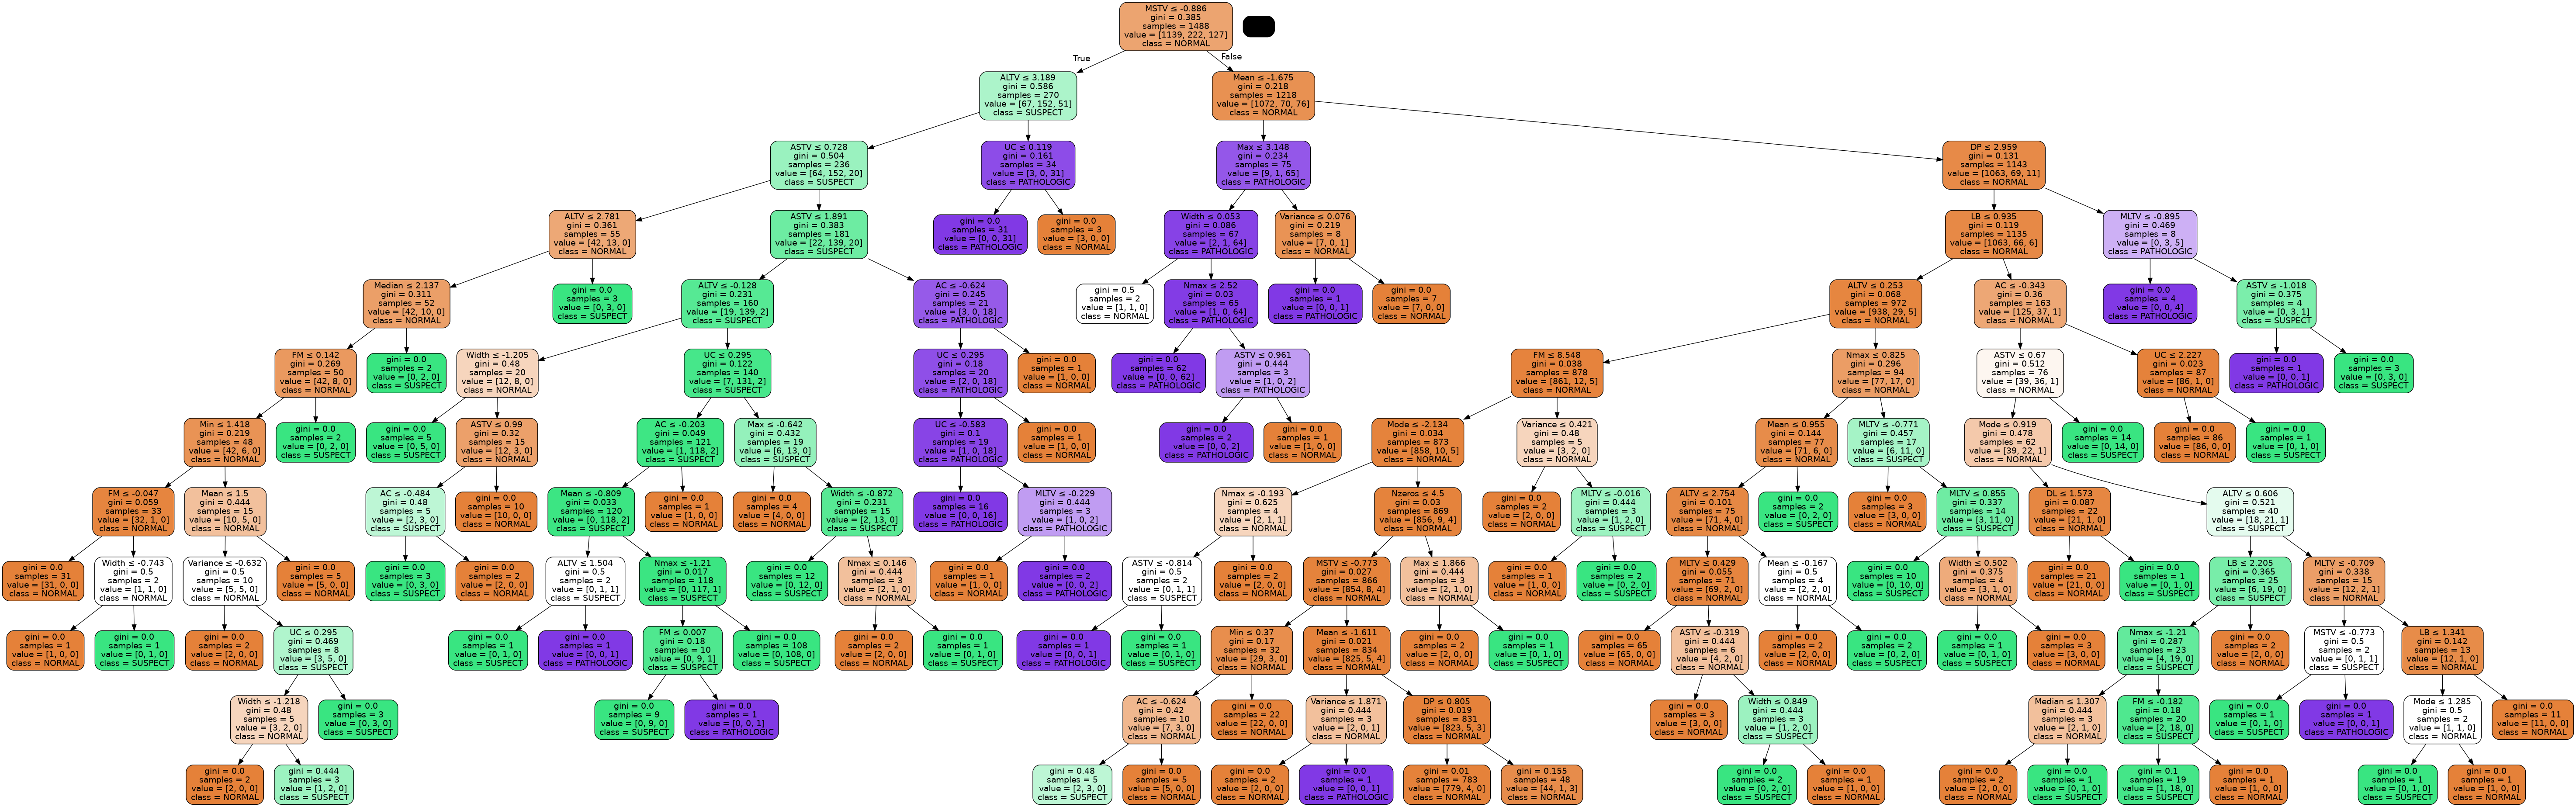

In [123]:
print("Melhor hyper-parametro:", grid_dt_gini.best_params_)
tree = grid_dt_gini.best_estimator_
target_names  = ['NORMAL', 'SUSPECT', 'PATHOLOGIC']

dot_data = StringIO()

export_graphviz(tree, out_file=dot_data,  
                filled=True,
                rounded=True,
                special_characters=True,
                feature_names = X.columns,
                class_names  = target_names)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

<hr>

### Entropy Métricas

In [124]:
y_pred = grid_dt_entropy.best_estimator_.predict(X_test)

### Métrica Acurácia

In [125]:
print("Acurácia :",metrics.accuracy_score(y_test,y_pred))

Acurácia : 0.9373040752351097


### Métrica Precisão

In [126]:
print("Precision micro:",metrics.precision_score(y_test,y_pred, average="micro"))
print("Precision macro:",metrics.precision_score(y_test,y_pred, average="macro"))

Precision micro: 0.9373040752351097
Precision macro: 0.8713310920757729


### Métrica de Revocação

In [127]:
print("RECALL micro:",metrics.recall_score(y_test,y_pred,average="micro"))
print("RECALL macro:",metrics.recall_score(y_test,y_pred,average="macro"))

RECALL micro: 0.9373040752351097
RECALL macro: 0.8683396795056559


### Árvore Entropy

{'criterion': 'entropy', 'max_depth': 23}


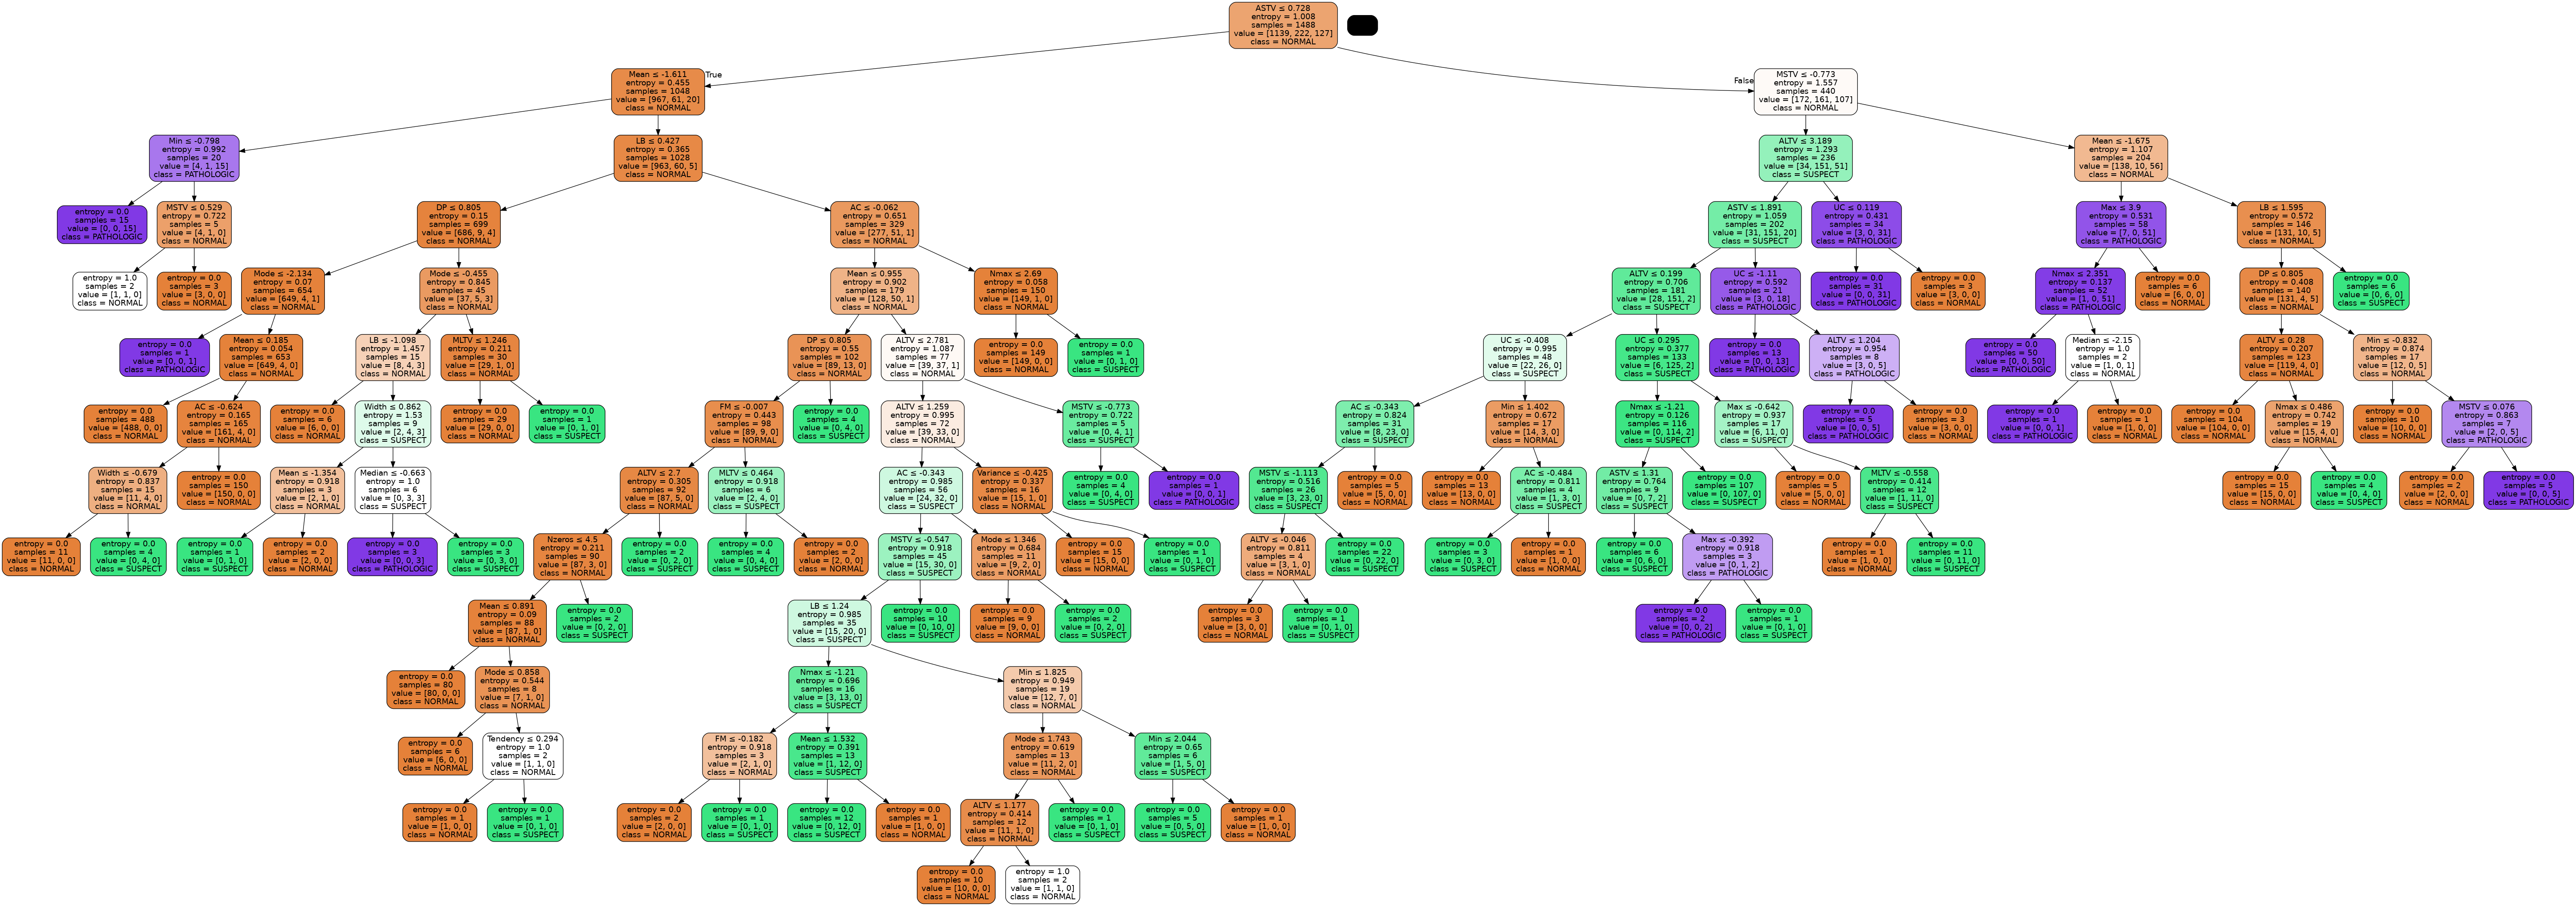

In [128]:

print(grid_dt_entropy.best_params_)
tree_entropy = grid_dt_entropy.best_estimator_
target_names  = ['NORMAL', 'SUSPECT', 'PATHOLOGIC']

dot_data = StringIO()

export_graphviz(tree_entropy, out_file=dot_data,  
                filled=True,
                rounded=True,
                special_characters=True,
                feature_names = X.columns,
                class_names  = target_names)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())


In [129]:
grid_dt_entropy.best_score_,grid_dt_gini.best_score_

(0.9381734083076363, 0.9287592962089606)

## SVM

### Linear

In [130]:
clf_svm_linear = svm.SVC()

param_grid_linear = [
    {'kernel':['linear'],
    'C':[0.001, 0.1, 1, 10, 100]}
    ]

linear_svm = GridSearchCV(clf_svm_linear, param_grid_linear, cv=10, n_jobs=None, verbose=8)
linear_svm.fit(X_train,y_train)

Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV 1/10] END ...........C=0.001, kernel=linear;, score=0.799 total time=   0.1s
[CV 2/10] END ...........C=0.001, kernel=linear;, score=0.779 total time=   0.0s
[CV 3/10] END ...........C=0.001, kernel=linear;, score=0.792 total time=   0.1s
[CV 4/10] END ...........C=0.001, kernel=linear;, score=0.792 total time=   0.1s
[CV 5/10] END ...........C=0.001, kernel=linear;, score=0.792 total time=   0.0s
[CV 6/10] END ...........C=0.001, kernel=linear;, score=0.785 total time=   0.0s
[CV 7/10] END ...........C=0.001, kernel=linear;, score=0.785 total time=   0.0s
[CV 8/10] END ...........C=0.001, kernel=linear;, score=0.799 total time=   0.0s
[CV 9/10] END ...........C=0.001, kernel=linear;, score=0.797 total time=   0.0s
[CV 10/10] END ..........C=0.001, kernel=linear;, score=0.784 total time=   0.0s
[CV 1/10] END .............C=0.1, kernel=linear;, score=0.893 total time=   0.0s
[CV 2/10] END .............C=0.1, kernel=linear;

GridSearchCV(cv=10, estimator=SVC(),
             param_grid=[{'C': [0.001, 0.1, 1, 10, 100], 'kernel': ['linear']}],
             verbose=8)

In [131]:
print("Melhor hyper-parametro: ", linear_svm.best_params_)

Melhor hyper-parametro:  {'C': 100, 'kernel': 'linear'}


In [132]:
y_pred = linear_svm.best_estimator_.predict(X_test)

### Métrica de Acurácia 

In [133]:
print('Accuracy       :', metrics.accuracy_score(y_test, y_pred))

Accuracy       : 0.8996865203761756


### Métrica de precisão

In [134]:
print('Precision macro:', metrics.precision_score(y_test, y_pred,average='macro'))
print('Precision micro:', metrics.precision_score(y_test, y_pred,average='micro'))

Precision macro: 0.7991434090505298
Precision micro: 0.8996865203761756


### Métrica de Revocação

In [135]:
print('Recall    macro:', metrics.recall_score(y_test, y_pred,average='macro'))
print('Recall    micro:', metrics.recall_score(y_test, y_pred,average='micro'))

Recall    macro: 0.8198156612119202
Recall    micro: 0.8996865203761756


<hr>

### RBF

In [136]:
clf_svm_rbf = svm.SVC()
param_grid_rbf = [
    {'kernel':['rbf'],
    'C': [0.001, 0.1, 1, 10, 100],
    'gamma': [0.5, 5, 10, 50, 100]}
    ]
rbf_svm = GridSearchCV(clf_svm_rbf, param_grid_rbf, cv=10, n_jobs=None, verbose=8)
rbf_svm.fit(X_train,y_train)

Fitting 10 folds for each of 25 candidates, totalling 250 fits
[CV 1/10] END ...C=0.001, gamma=0.5, kernel=rbf;, score=0.765 total time=   0.1s
[CV 2/10] END ...C=0.001, gamma=0.5, kernel=rbf;, score=0.765 total time=   0.1s
[CV 3/10] END ...C=0.001, gamma=0.5, kernel=rbf;, score=0.765 total time=   0.0s
[CV 4/10] END ...C=0.001, gamma=0.5, kernel=rbf;, score=0.765 total time=   0.0s
[CV 5/10] END ...C=0.001, gamma=0.5, kernel=rbf;, score=0.765 total time=   0.0s
[CV 6/10] END ...C=0.001, gamma=0.5, kernel=rbf;, score=0.765 total time=   0.0s
[CV 7/10] END ...C=0.001, gamma=0.5, kernel=rbf;, score=0.765 total time=   0.0s
[CV 8/10] END ...C=0.001, gamma=0.5, kernel=rbf;, score=0.765 total time=   0.0s
[CV 9/10] END ...C=0.001, gamma=0.5, kernel=rbf;, score=0.770 total time=   0.0s
[CV 10/10] END ..C=0.001, gamma=0.5, kernel=rbf;, score=0.764 total time=   0.0s
[CV 1/10] END .....C=0.001, gamma=5, kernel=rbf;, score=0.765 total time=   0.1s
[CV 2/10] END .....C=0.001, gamma=5, kernel=rb

GridSearchCV(cv=10, estimator=SVC(),
             param_grid=[{'C': [0.001, 0.1, 1, 10, 100],
                          'gamma': [0.5, 5, 10, 50, 100], 'kernel': ['rbf']}],
             verbose=8)

In [137]:
print("Melhor hyper-parametro:", rbf_svm.best_params_)

Melhor hyper-parametro: {'C': 10, 'gamma': 0.5, 'kernel': 'rbf'}


In [138]:
y_pred = rbf_svm.best_estimator_.predict(X_test)

### Métrica de Acurácia

In [139]:
print('Accuracy       :', metrics.accuracy_score(y_test, y_pred))

Accuracy       : 0.8824451410658307


### Métrica de Precisão

In [140]:
print('Precision macro:', metrics.precision_score(y_test, y_pred,average='macro'))
print('Precision micro:', metrics.precision_score(y_test, y_pred,average='micro'))

Precision macro: 0.8534165181224006
Precision micro: 0.8824451410658307


### Métrica de Revocação

In [141]:
print('Recall    macro:', metrics.recall_score(y_test, y_pred,average='macro'))
print('Recall    micro:', metrics.recall_score(y_test, y_pred,average='micro'))

Recall    macro: 0.6458747351547606
Recall    micro: 0.8824451410658307
